In [1]:
# Imports
import numpy as np
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.providers.fake_provider import FakeManilaV2
from qiskit.tools.monitor import job_monitor
import matplotlib.pyplot as plt
from qiskit.visualization import *
from qiskit.circuit.library import HGate, RXGate, PhaseGate

In [2]:
# Set global Variables

# number of qubits
n = 4
# lambda value
lambd = 1.2

In [3]:
# Functions 
def thetak(k, lamb):
    """ Calculate a theta_k given k and lamba
    Args:
        k: k value
        lamb: lambda value
    Returns:
        double: Value of theta
    """
    num = lamb - np.cos(2 * np.pi * k / n)
    denom = np.sqrt(
        (lamb - np.cos(2 * np.pi * k / n)) ** 2 + np.sin(2 * np.pi * k / n) ** 2
    )
    theta = np.arccos(num / denom)
    return theta

def bogo(qcirc, qubits, theta):
    """ Apply the Bogoliubov gate to a quantum circuit.
    Args:
        qcirc: Qiskit Quantum Circuit. This circuit will be modified in place.
        qubits: List of Qubits to apply the circuits to. Often obtained with circuit.qubits
        theta: Angle to rotate in the X-axis by the controlled RX gate
    """
    qcirc.x(qubits[1])
    qcirc.cx(qubits[1], qubits[0])
    qcirc.crx(theta, qubits[0], qubits[1])
    qcirc.cx(qubits[1], qubits[0])
    qcirc.x(qubits[1])
    qcirc.barrier()

def bogoDag(qcirc, qubits, theta):
    """ Apply the Bogoliubov Dagger gate to a quantum circuit.
    Args:
        qcirc: Qiskit Quantum Circuit. This circuit will be modified in place.
        qubits: List of Qubits to apply the circuits to. Often obtained with circuit.qubits
        theta: Angle to rotate in the X-axis by the controlled RX gate
    """
    qcirc.x(qubits[1])
    qcirc.cx(qubits[1], qubits[0])
    qcirc.crx(theta, qubits[0], qubits[1])
    qcirc.cx(qubits[1], qubits[0])
    qcirc.x(qubits[1])

def digit_sum(n):
    """ Sum the digits of a number.
    Args:
        n: Number to sum the digits of
    Returns:
        int: Sum of digits in number
    """
    num_str = str(n)
    sum = 0
    for i in range(0, len(num_str)):
        sum += int(num_str[i])
    return sum

def executeJobAndGetMagnetization(qcirc, backend, shots, max_credits):
    """ Execute the passed in Circuit as a job and return the magnetization results.
    Args:
        qcirc: Qiskit Quantum Circtuit to be run
        backend: Backend to run the job against
        shots: Number of shots to run the job
        max_credits: Maximum credits to be used for the job
    Return:
        float[]: Magnetization results from jobs
    """
    # magnetization
    mag = []
    job = execute(qcirc, backend=backend, shots=shots, max_credits=max_credits)
    job_monitor(job)
    result = job.result()
    counts = result.get_counts(qcirc)

    r1 = list(counts.keys())
    r2 = list(counts.values())
    M = 0
    for j in range(0, len(r1)):
        M = M + (4 - 2 * digit_sum(r1[j])) * r2[j] / shots
    # print("$\lambda$: ",lam,", $<\sigma_{z}>$: ",M/4)
    mag.append(M / 4)
    return mag

def fermionicSwap(qcirc, qubits):
    """ Apply fermionic swap gate to quantum circuit.
    Args:
        qcirc: Qiskit Quantum Circuit. This circuit will be modified in place.
        qubits: List of Qubits to apply the circuits to. Often obtained with circuit.qubits
    """
    qcirc.swap(qubits[0], qubits[1])
    qcirc.cz(qubits[0], qubits[1])

def Fourier(qcirc, qubits, n, k):
    """ Apply Fast Fourier transform gates to circuit.
    Args:
        qcirc: Qiskit Quantum Circuit. This circuit will be modified in place.
        qubits: List of Qubits to apply the circuits to. Often obtained with circuit.qubits
        n: Number of qubits
        k: k value
    """
    qcirc.p(2 * np.pi * k / n, qubits[0])
    qcirc.cx(qubits[0], qubits[1])
    qcirc.ch(qubits[1], qubits[0])
    qcirc.cx(qubits[0], qubits[1])
    qcirc.cz(qubits[0], qubits[1])

def FourierDag(circuit, qubits, n, k):
    """ Apply Fast Fourier Dagger transform gates to quantum circuit.
    Args:
        qcirc: Qiskit Quantum Circuit. This circuit will be modified in place.
        qubits: List of Qubits to apply the circuits to. Often obtained with circuit.qubits
        n: Number of qubits
        k: k value
    """
    # Other implementations may use sdgGate instead of the phase gate, but a phase gate with -Pi/2 is the same as sdg
    inversePhaseGate = PhaseGate(2 * np.pi * k / n).inverse()
    circuit.append(inversePhaseGate, qubits[0:1])
    circuit.cx(qubits[0], qubits[1])
    circuit.ch(qubits[1], qubits[0])
    circuit.cx(qubits[0], qubits[1])
    circuit.cz(qubits[0], qubits[1])

def applyDisentaglementGates(qcirc, lamb):
    """ Apply the Disentaglement Gates to the quantum circuit.
    Args:
        qcirc: Qiskit Quantum Circuit. This circuit will be modified in place.
        lamb: lambda value
    """
    bogoDag(qcirc, qcirc.qubits[0:2], thetak(1,lamb))
    qcirc.barrier()
    FourierDag(qcirc, qcirc.qubits[0:2], 4, 1)
    FourierDag(qcirc, qcirc.qubits[2:4], 4, 0)
    qcirc.barrier()
    FourierDag(qcirc, qcirc.qubits[0:2], 4, 0)
    FourierDag(qcirc, qcirc.qubits[2:4], 4, 0)


def ground_state(lamb):
    """ Create the ground state for running the transverse Ising-model circuit, then apply the disentaglement gates and run the circuit.
    Args:
        lamb: lambda value
    Return:
        float[]: Magnetizations for runnin the job
    """
    # Create a quantum Circuit with 4 quantum bits and 4 classical
    qcirc = QuantumCircuit(4, 4)
    # Set correct ground state if lambda < 1
    if lamb < 1:
        qcirc.x(3)
        qcirc.barrier()

    applyDisentaglementGates(qcirc, lamb)
    # Set measurement step
    for i in range(0, 4):
        qcirc.measure(i, i)

    return executeJobAndGetMagnetization(qcirc, FakeManilaV2(), 1024, 10)

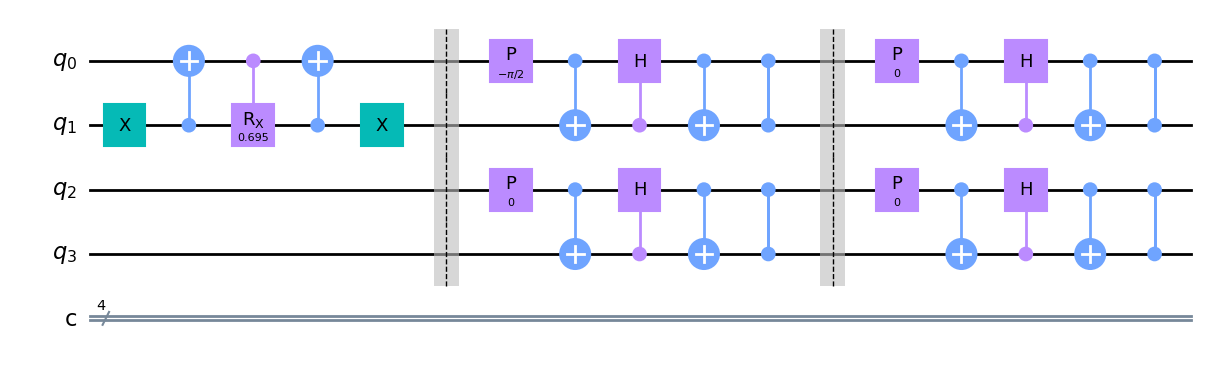

In [4]:
# Draws the Ising Model circuit
paperBasedCirc = QuantumCircuit(4,4)
if lambd < 1:
    paperBasedCirc.x(3)
    paperBasedCirc.barrier()
applyDisentaglementGates(paperBasedCirc, lambd)
paperBasedCirc.draw('mpl')

In [5]:
# Run the circuit over a range of lambdas
lmbd = np.arange(0, 1.75, 0.1)
sigmaz = []
for l in lmbd:
    sigmaz.append(ground_state(l))

print(sigmaz)

c:\Users\timmy\OneDrive\GradSchool\QuantumInfo\qiskitEnvironment\lib\site-packages\qiskit\providers\fake_provider\fake_backend.py:354: RuntimeWarning: Aer not found using BasicAer and no noise
  warnings.warn("Aer not found using BasicAer and no noise", RuntimeWarning)
c:\Users\timmy\OneDrive\GradSchool\QuantumInfo\qiskitEnvironment\lib\site-packages\qiskit\utils\deprecation.py:182: UserWarning: Option max_credits is not used by this backend
  return func(*args, **kwargs)


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
[[0.0107421875], [0.0361328125], [0.10546875], [0.1240234375], [0.1875], [0.2197265625], [0.255859375], [0.28515625], [0.3193359375], [0.3203125], [0.830078125], [0.884765625], [0.875], [0.88671875], [0.90625], [0.90625], [0.9267578125], [0.919921875]]


(0.0, 1.8)

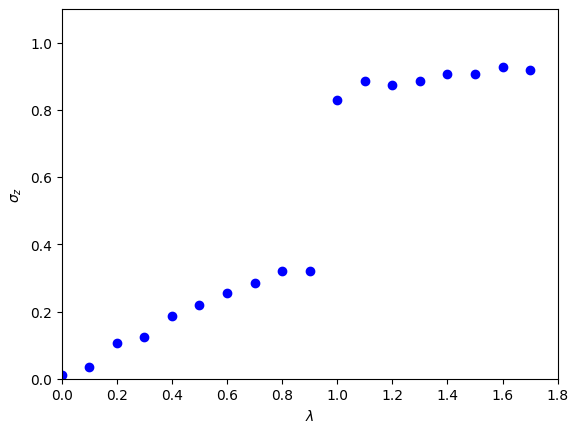

In [6]:
# Plot the magnetization values for the range of lambdas

plt.plot(lmbd, sigmaz, "bo")
plt.ylabel("$\\sigma_z$")
plt.xlabel("$\\lambda$")
plt.ylim(0.0, 1.1)
plt.xlim(0.0, 1.8)

Job Status: job has successfully run


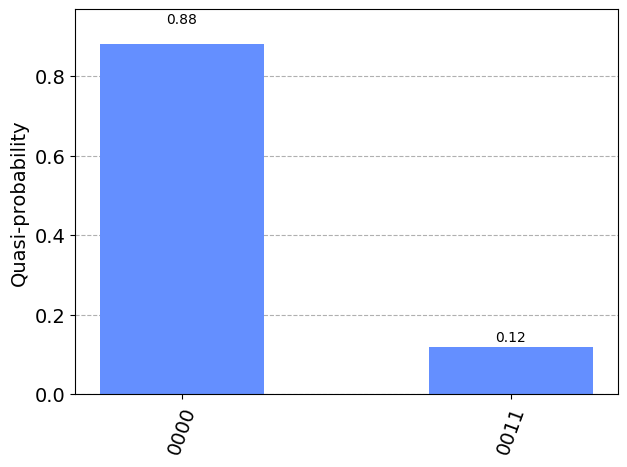

In [7]:
# Create a distribution plot for the states found by the jobs
# Measurement
qcirc = QuantumCircuit(4, 4)
# Set correct ground state if lambda < 1
if lambd < 1:
    qcirc.x(3)
    qcirc.barrier()

# Apply disentangling gates
applyDisentaglementGates(qcirc, lambd)
# Set measurement step
for i in range(0, 4):
    qcirc.measure(i, i)


# Using a fake backend provided with qiskit

backend = FakeManilaV2()

shots = 1024
max_credits = 10  # Max number of credits to spend on execution
job = execute(qcirc, backend=backend, shots=shots, max_credits=max_credits)
job_monitor(job)
result = job.result()
counts = result.get_counts(qcirc)

plot_distribution(counts)

# had to comment this part because qc is a local variable in groundstate function now - Bruna

In [8]:
# Calculate expected probabilites of states

phi = np.arccos(lambd / np.sqrt(1 + lambd**2)) / 2
# print(result.get_statevector(qc))
print("|0000> probability should be: ", np.cos(phi) ** 2)
print("|0011> probability should be: ", np.sin(phi) ** 2)

|0000> probability should be:  0.8841106397986879
|0011> probability should be:  0.11588936020131207


In [9]:
def wire(n=4):
    """ Create a quantum circuit and initialize the ground state.
    Args:
        n: Number of qubits in circuit
    """
    qcirc = QuantumCircuit(n, n)
    if lambd < 1:
        qcirc.x(3)
        qcirc.barrier()
    
    return qcirc

def time_evol(t, lambd, backend_name, qcirc):
    """ Perform time evolution of the Ising Model.
    Args:
        t: Time values to evolve over
        lambd: Lambda value
        backend_name: Name of the backend to run on.
        qcirc: Quantum Circuit to time evolve.
    Return:
        float[]: Magnetization results
    """
    # This line seems to do everything time related for the transform
    qcirc.u(np.arccos(lambd/np.sqrt(1+lambd**2)), np.pi/2 + 4*t*np.sqrt(1+lambd**2), 0, 0)
    qcirc.cx(0, 1)
    
    mag = []
    
    applyDisentaglementGates(qcirc, lambd)
    
    for i in range(0,4):
        qcirc.measure(i,i)
    
    backend = BasicAer.get_backend(backend_name)
    
    shots = 1024
    max_credits = 10 
    job = execute(qcirc, backend=backend, shots=shots, max_credits=max_credits)
    job_monitor(job)
    result = job.result()
    counts = result.get_counts(qcirc)
    
    r1=list(counts.keys())
    r2=list(counts.values())
    M=0
    for j in range(0,len(r1)):
        M=M+(4-2*digit_sum(r1[j]))*r2[j]/shots

    mag.append(M/4)
    return mag

time = np.arange(0, 2.5, 0.05)
sigmaz = []

for t in time:
    sigmaz.append(time_evol(t, lambd, 'qasm_simulator', wire()))

c:\Users\timmy\OneDrive\GradSchool\QuantumInfo\qiskitEnvironment\lib\site-packages\qiskit\utils\deprecation.py:182: UserWarning: Option max_credits is not used by this backend
  return func(*args, **kwargs)


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
J

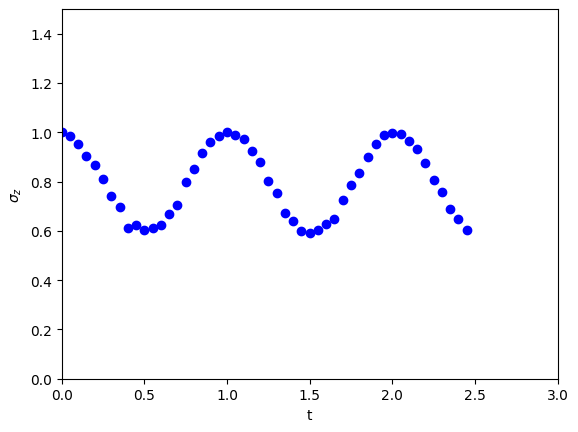

In [10]:
# Plot the time evolution

plt.plot(time, sigmaz, "bo")
plt.ylim(0., 1.5)
plt.xlim(0., 3)
plt.ylabel("$\sigma_z$")
plt.xlabel("t")
plt.show()

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


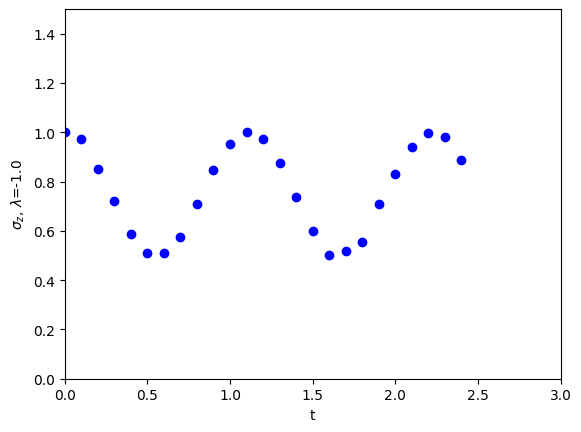

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


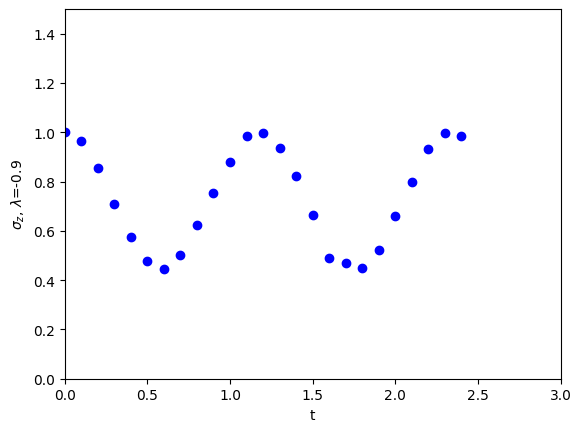

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


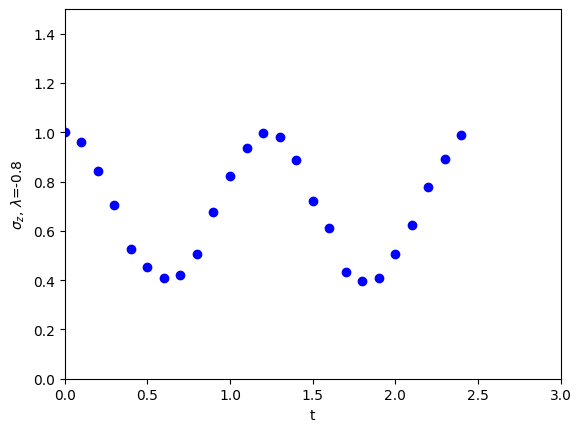

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


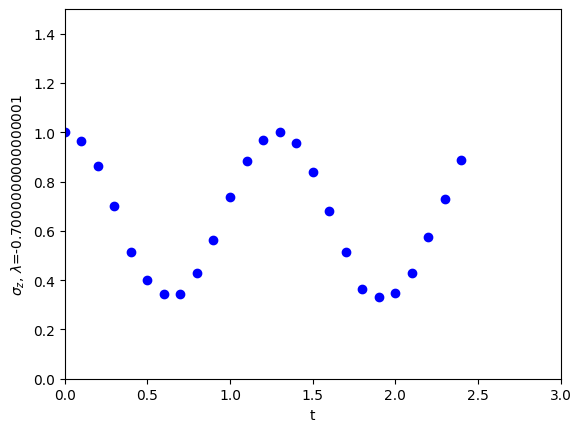

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


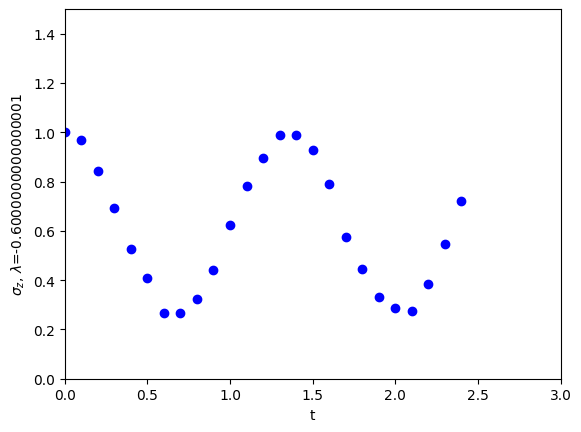

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


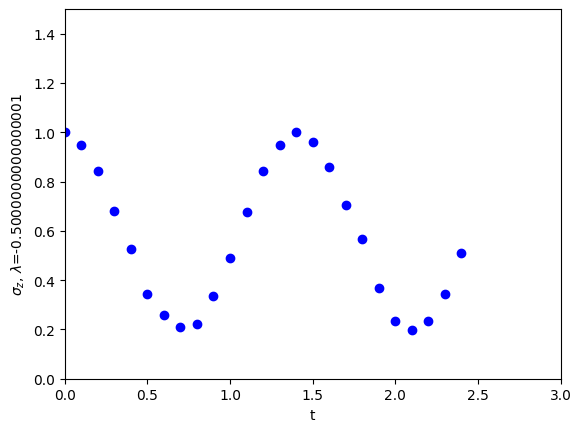

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


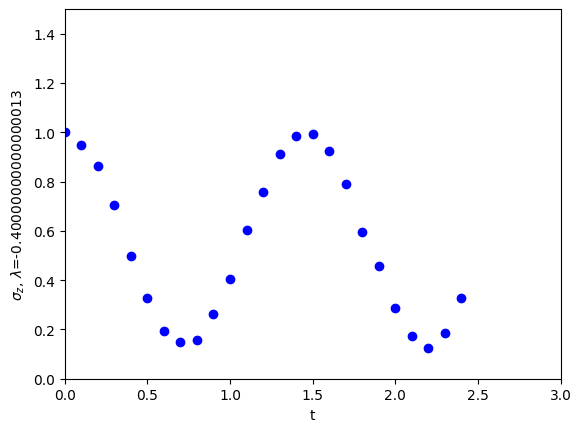

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


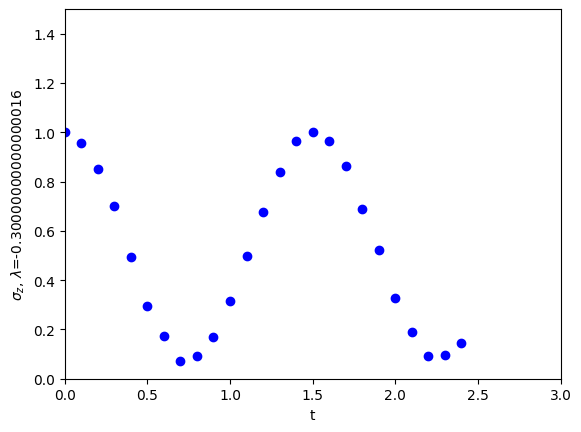

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


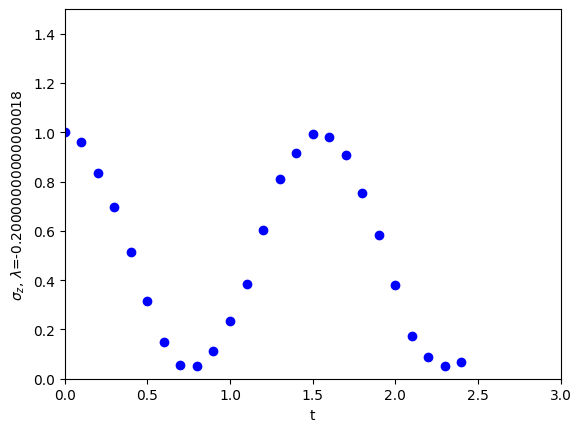

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


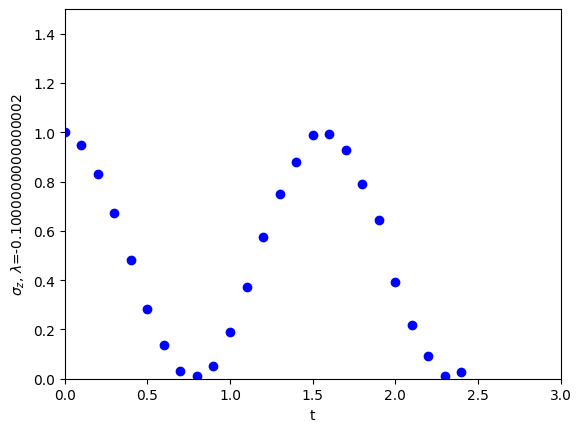

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


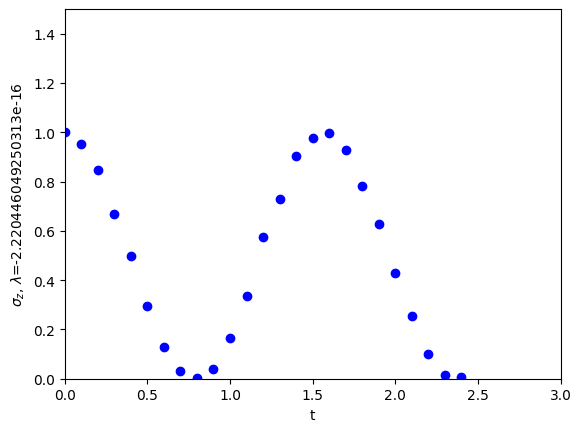

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


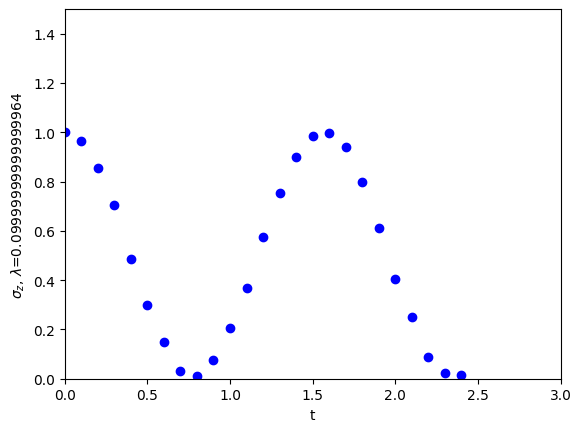

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


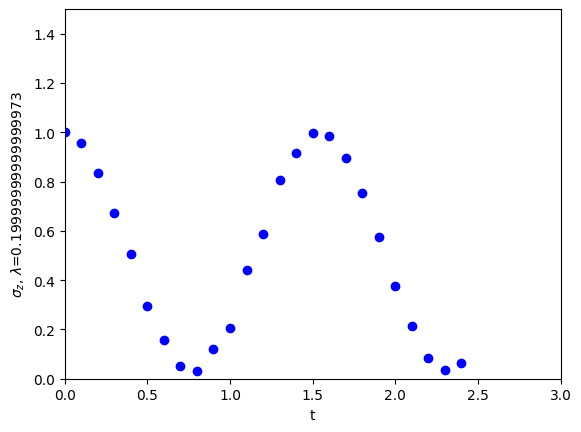

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


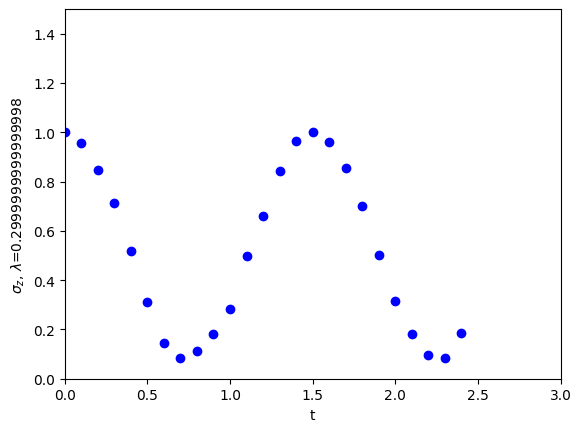

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


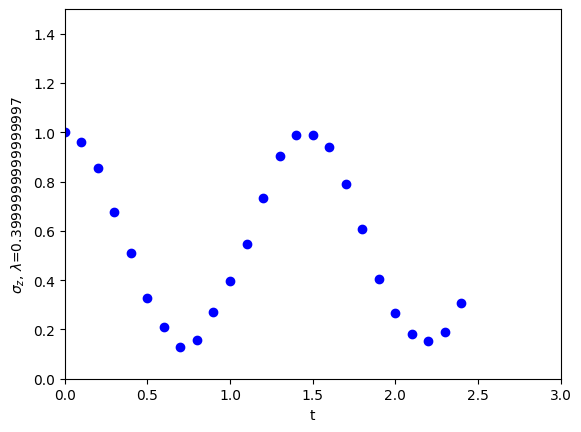

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


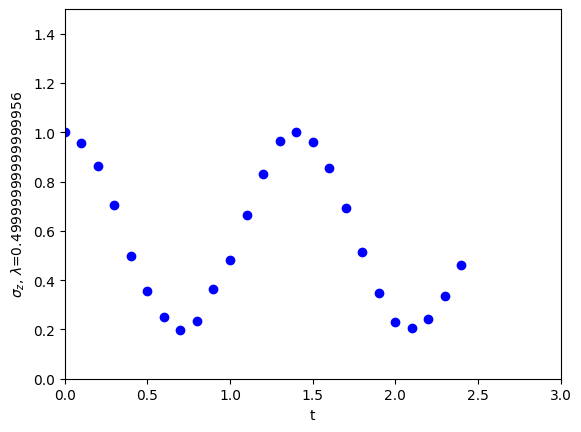

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


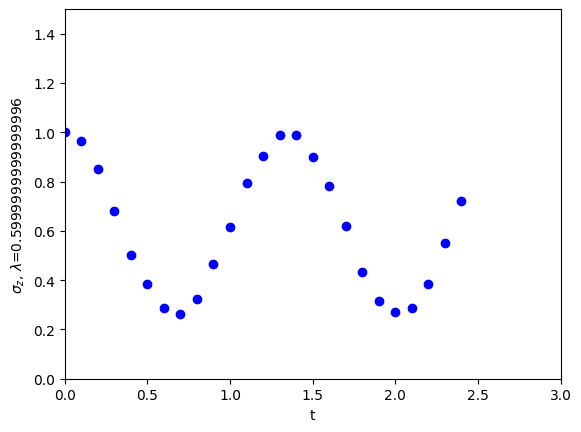

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


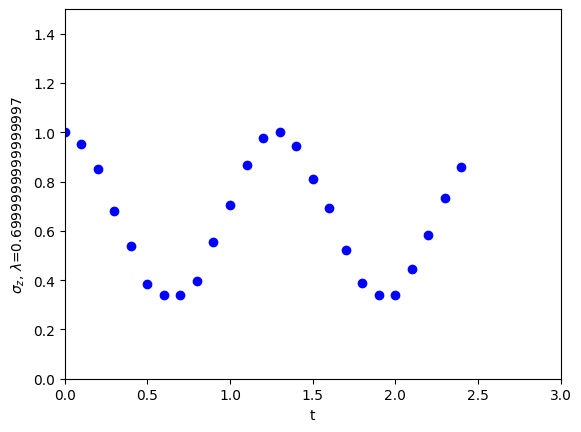

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


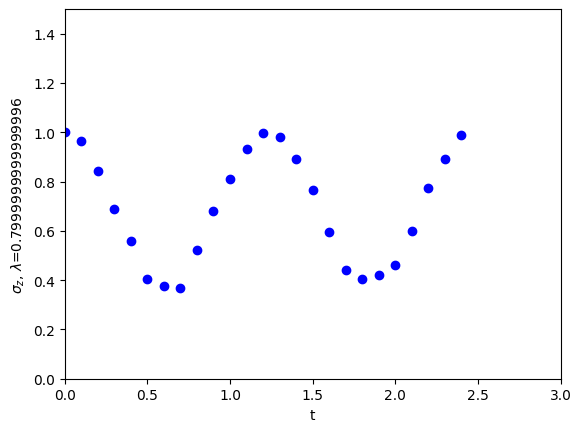

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


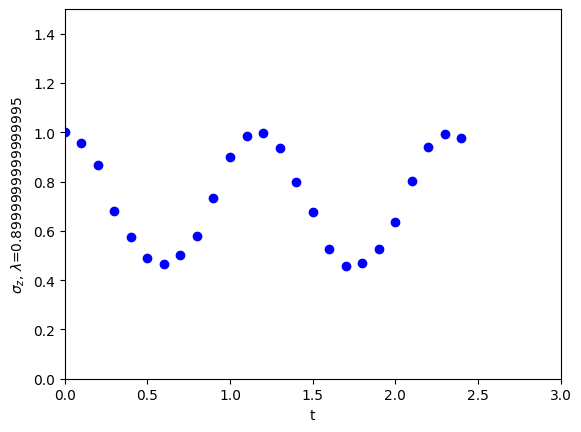

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


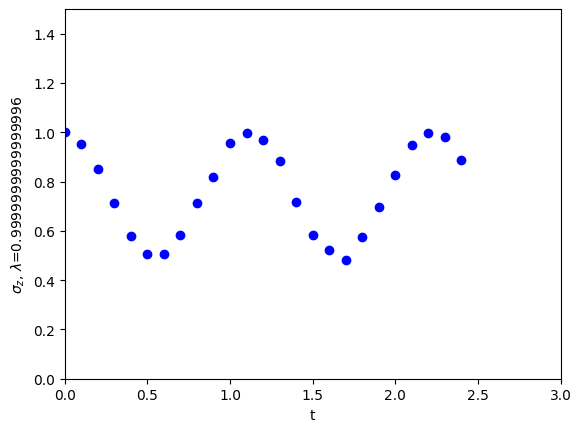

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


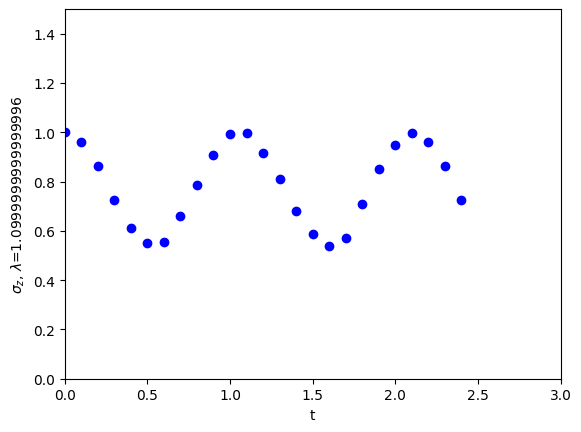

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


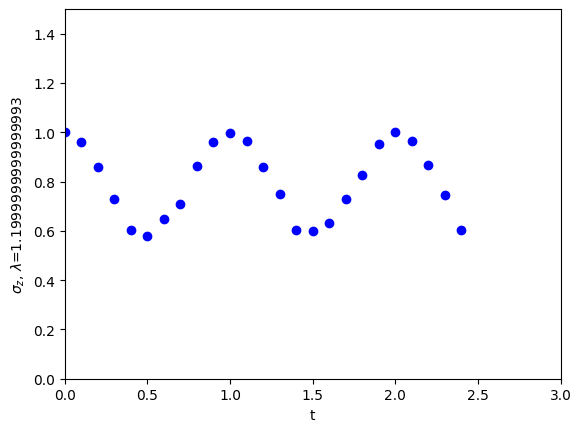

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


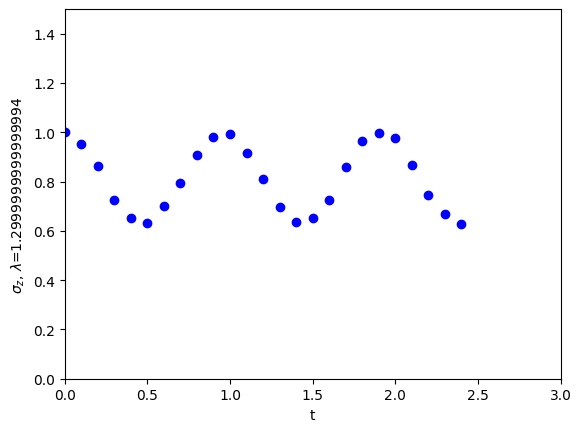

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


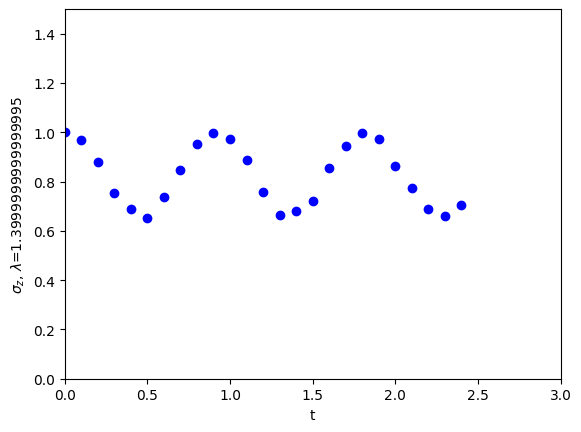

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


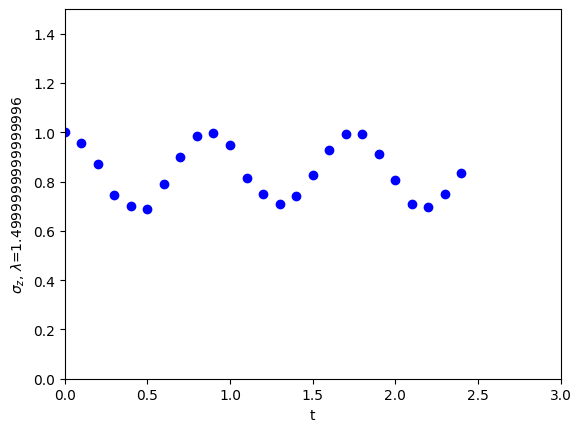

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


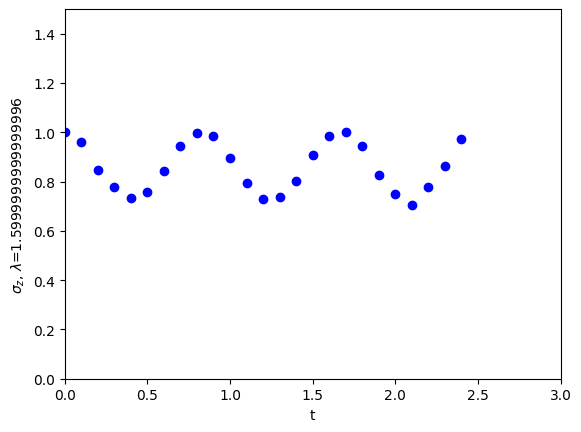

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


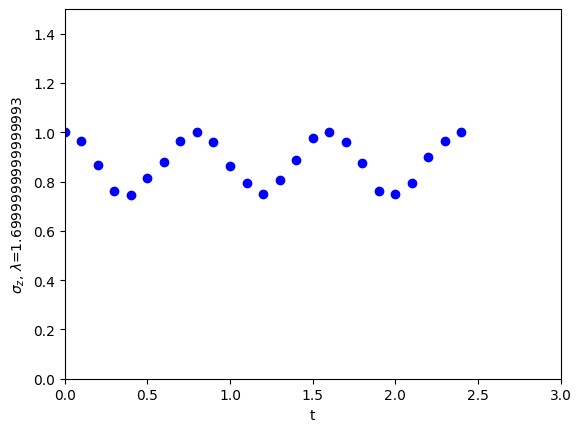

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


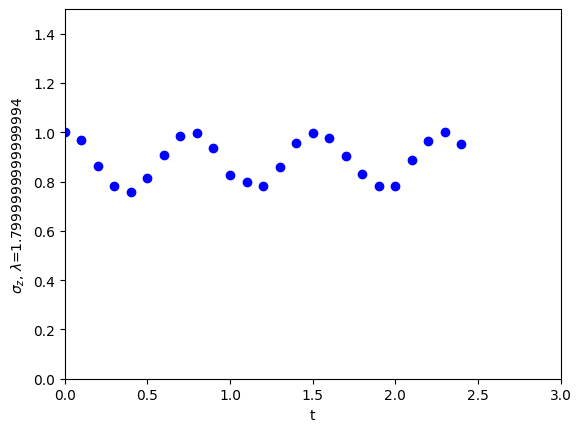

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


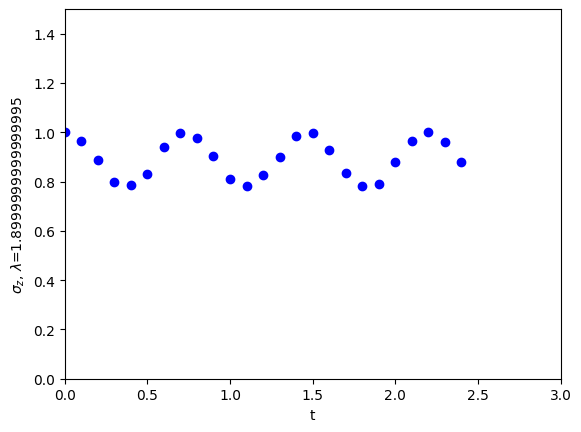

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


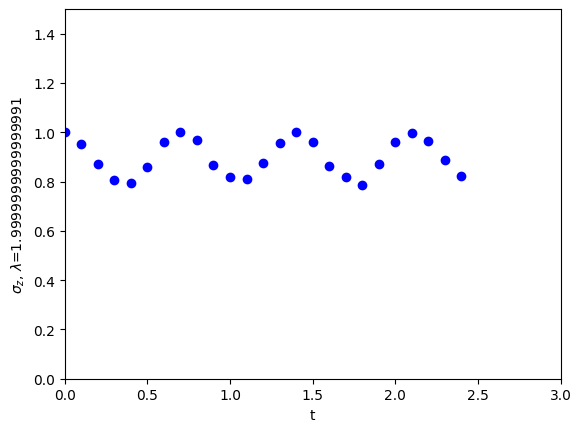

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


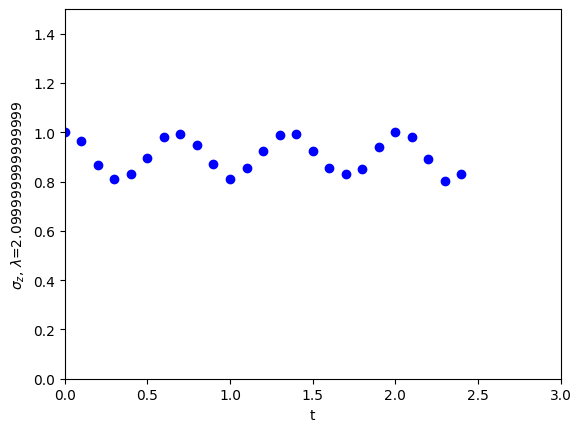

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


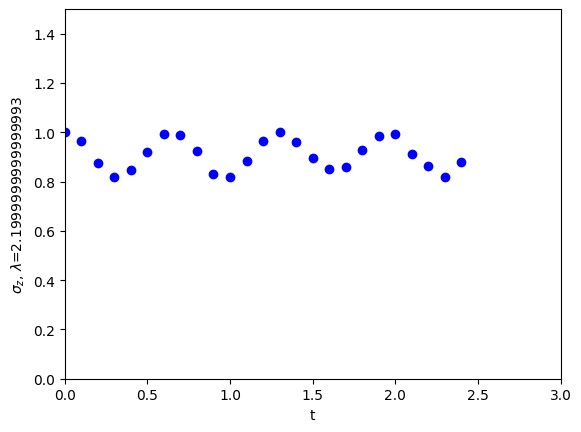

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


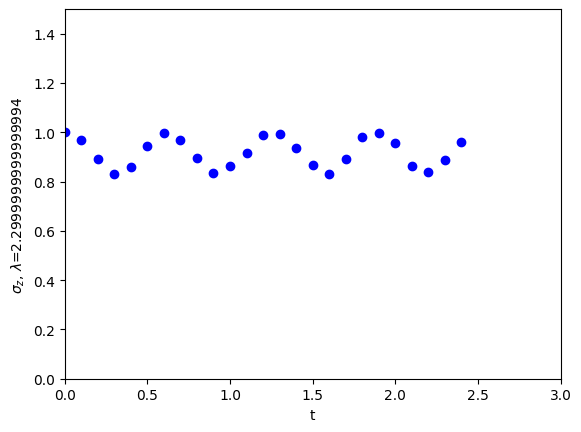

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


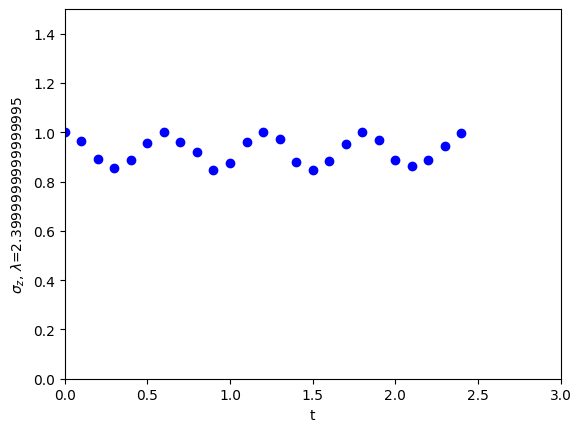

In [12]:
def plot(mag, time, lamb):
    plt.plot(time, mag, "bo")
    plt.ylim(0., 1.5)
    plt.xlim(0., 3)
    plt.ylabel("$\sigma_z$, $\lambda$={}".format(lamb))
    plt.xlabel("t")
    plt.show()

lambda_list = np.arange(-1, 2.5, 0.1)
time_list = np.arange(0, 2.5, 0.1)

for i in lambda_list:
    sigmaz = []
    for j in time_list:
        sigmaz.append(time_evol(j, i, 'qasm_simulator', wire()))
    plot(sigmaz, time_list, i)